<a href="https://colab.research.google.com/github/myomyint-maung/nlp-assignments/blob/main/07-Machine-Translation/07_Machine_Translation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 23 Feb - Machine Translation from Myanmar to English

In [1]:
# Import necessary libraries
import torch, torchtext
from torch import nn
import torch.nn.functional as F
import random, math, time

# Choose the computing device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Set SEED for reproducibility
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

cuda


## 1. Loading Data

**Note**: I use the Myanmar and English datasets from the Asian Language Treebank (ALT) Parallel Corpus available at https://www2.nict.go.jp/astrec-att/member/mutiyama/ALT/.

In [2]:
# Load the datasets
import pandas as pd

data_my = pd.read_csv('/content/nlp-assignments/07-Machine-Translation/data/data_my.txt', sep='\t', header=None)
data_en = pd.read_csv('/content/nlp-assignments/07-Machine-Translation/data/data_en.txt', sep='\t', header=None)

data_my.columns = ['REF', 'MY']
data_en.columns = ['REF', 'EN']

df = pd.merge(data_my, data_en, on='REF')
df = df.drop('REF', axis=1)
df = df.dropna()

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19166 entries, 0 to 19172
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   MY      19166 non-null  object
 1   EN      19166 non-null  object
dtypes: object(2)
memory usage: 449.2+ KB


,MY,EN
0,ပြင်သစ်နိုင်ငံ ပါရီမြို့ ပါ့ဒက်စ် ပရင့်စက် ၌ ၂...,Italy have defeated Portugal 31-5 in Pool C of...
1,အန်ဒရီယာ မာစီ သည် အီတလီ အတွက် စမ်းသပ်မှု တစ်ခု...,Andrea Masi opened the scoring in the fourth m...
2,ပထမ တစ်ဝက် ၏ တော်တော်များများ အတွက် ကစားပွဲ ကိ...,Despite controlling the game for much of the f...
3,ပေါ်တူဂီ သည် ဘယ်သောအခါမှ စွန့်လွှတ်မှု မရှိခဲ့...,Portugal never gave up and David Penalva score...
4,အီတလီ သည် ပထမပိုင်း ၌ ၁၆-၅ ဖြင့် ဦးဆောင်ခဲ့ သေ...,Italy led 16-5 at half time but were matched b...


In [3]:
# Convert the dataframe into a list of parallel corpus
corpus = df.values.tolist()

corpus[0:5]

[['ပြင်သစ်နိုင်ငံ ပါရီမြို့ ပါ့ဒက်စ် ပရင့်စက် ၌ ၂၀၀၇ခုနှစ် ရပ်ဘီ ကမ္ဘာ့ ဖလား တွင် အီတလီ သည် ပေါ်တူဂီ ကို ၃၁-၅ ဂိုး ဖြင့် ရေကူးကန် စီ တွင် ရှုံးနိမ့်သွားပါသည် ။',
  'Italy have defeated Portugal 31-5 in Pool C of the 2007 Rugby World Cup at Parc des Princes, Paris, France.'],
 ['အန်ဒရီယာ မာစီ သည် အီတလီ အတွက် စမ်းသပ်မှု တစ်ခု အဖြစ် စတုတ္ထ မိနစ် တွင် အမှတ်ပေးခြင်း ကို ဖွင့်လှစ်ပေးခဲ့သည် ။',
  'Andrea Masi opened the scoring in the fourth minute with a try for Italy.'],
 ['ပထမ တစ်ဝက် ၏ တော်တော်များများ အတွက် ကစားပွဲ ကို ထိန်းချုပ်ခြင်း မရှိခဲ့လျှင် အီတလီ သည် ပွဲနားချိန် မတိုင်မှီ အခြား မည်သည့် ကြိုးစားမှု များ ကိုမှ အမှတ် မရနိုင် ပေမယ့် ဒေးဗစ် ဘော်တိုလပ်စီ သည် သူတို့၏ ဦးဆောင်မှု ကို အဓွန့်ရှည် စေရန် ပယ်နယ်လ်တီ ၃ဂိုး သွင်းပေးခဲ့သည် ။',
  'Despite controlling the game for much of the first half, Italy could not score any other tries before the interval but David Bortolussi kicked three penalties to extend their lead.'],
 ['ပေါ်တူဂီ သည် ဘယ်သောအခါမှ စွန့်လွှတ်မှု မရှိခဲ့ ပဲ ဒေးဗစ် ပန်နယ်ဗါ သည်

## 2. Splitting Data

In [4]:
# Check the size of the corpus
len(corpus)

19166

In [5]:
# Split the corpus into training, validataion and test sets
random.shuffle(corpus)

train_size = int(len(corpus) * 0.8)
val_size   = int(len(corpus) * 0.1)

train_set = corpus[:train_size]
val_set   = corpus[train_size:(train_size + val_size)]
test_set  = corpus[(train_size + val_size):]

len(train_set), len(val_set), len(test_set)

(15332, 1916, 1918)

## 3. Preprocessing 

### Tokenizing

In [6]:
# Assign the source and target languages
SRC_LANGUAGE = 'MY'
TRG_LANGUAGE = 'EN'

In [7]:
# Assign place-holders
token_transform = {}
vocab_transform = {}

In [8]:
# Creat the Myanmar tokenizer
import pyidaungsu.tokenize as tokenize

def myanmar_tokenizer(text):
    return tokenize(text, form='word')

token_transform[SRC_LANGUAGE] = myanmar_tokenizer

print("Sentence: ", train_set[0][0])
print("Tokenization: ", token_transform[SRC_LANGUAGE](train_set[0][0]))

Sentence:  “ ပီအေ - ၄၅၇ ကို ကြာရှည်ထားခံခြင်း အတွက် ရွေးချယ်ခြင်း မဟုတ်ပဲ အသုံးပြုရ လွယ်ကူ ပြီး ၊ အဆိပ် - မဖြစ်စေခဲ့ လျှင် ၊ ၄င်း ကို ကောင်း မွန်သော အသုံးချ စရာ တွေ့ရှိလိမ့်မယ် ” ဟု ၊ နယ်သာလန် ရှိ ယူတရီချ် တက္ကသိုလ် ဆေးပညာ စင်တာ ၌ အိတ်အိုင်ဗွီ ပိုး စမ်းသပ် နေသူ ချားလ်စ ဘိုချာ က ပြောခဲ့သည် ။
Tokenization:  ['“', 'ပီအေ', '-', '၄၅၇', 'ကို', 'ကြာရှည်', 'ထားခံ', 'ခြင်း', 'အတွက်', 'ရွေးချယ်', 'ခြင်း', 'မ', 'ဟုတ်', 'ပဲ', 'အသုံးပြု', 'ရ', 'လွယ်ကူ', 'ပြီး', '၊', 'အဆိပ်', '-', 'မ', 'ဖြစ်', 'စေ', 'ခဲ့', 'လျှင်', '၊', '၄င်း', 'ကို', 'ကောင်းမွန်', 'သော', 'အသုံးချ', 'စရာ', 'တွေ့', 'ရှိ', 'လိမ့်', 'မယ်', '”', 'ဟု', '၊', 'နယ်သာလန်', 'ရှိယူတရီချ်', 'တက္ကသိုလ်', 'ဆေး', 'ပညာ', 'စင်တာ', '၌', 'အိတ်အိုင်ဗွီပိုးစမ်းသပ်', 'နေ', 'သူ', 'ချားလ်စဘိုချာ', 'က', 'ပြော', 'ခဲ့', 'သည်', '။']


In [9]:
# Creat the English tokenizer
from torchtext.data.utils import get_tokenizer
token_transform[TRG_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')

print("Sentence: ", train_set[0][1])
print("Tokenization: ", token_transform[TRG_LANGUAGE](train_set[0][1]))

Sentence:  If PA-457 turns out to be non-toxic, easy to use and not to select for resistance, it will find good use, said Charles Boucher who researches HIV at Utrecht university medical center in the Netherlands.
Tokenization:  ['If', 'PA-457', 'turns', 'out', 'to', 'be', 'non', '-', 'toxic', ',', 'easy', 'to', 'use', 'and', 'not', 'to', 'select', 'for', 'resistance', ',', 'it', 'will', 'find', 'good', 'use', ',', 'said', 'Charles', 'Boucher', 'who', 'researches', 'HIV', 'at', 'Utrecht', 'university', 'medical', 'center', 'in', 'the', 'Netherlands', '.']


In [10]:
# helper function to yield list of tokens
# here data can be `train` or `val` or `test`
def yield_tokens(data, language):
    language_index = {SRC_LANGUAGE: 0, TRG_LANGUAGE: 1}

    for data_sample in data:
        yield token_transform[language](data_sample[language_index[language]]) #either first or second index

In [11]:
# Define special symbols and indices
UNK_IDX, PAD_IDX, SOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<sos>', '<eos>']

### Numericalization

In [12]:
# Build vocabulary
from torchtext.vocab import build_vocab_from_iterator

for ln in [SRC_LANGUAGE, TRG_LANGUAGE]: 
    vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(train_set, ln), 
                                                    min_freq=2,
                                                    specials=special_symbols,
                                                    special_first=True)

for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    vocab_transform[ln].set_default_index(UNK_IDX)

In [13]:
# Save vocab
import pickle

file_path = './nlp-assignments/07-Machine-Translation/vocab_transform.pkl'

with open(file_path, 'wb') as file:
    pickle.dump(vocab_transform, file)

In [14]:
#see some examples
print(vocab_transform[SRC_LANGUAGE](['ပြင်သစ်', 'အီတလီ', 'ကုလသမဂ္ဂ', 'ဘလာဘလာ', 'ကုလသမဂ္ဂ']))
print(vocab_transform[TRG_LANGUAGE](['here', 'is', 'a', 'unknownword', 'a']))

[382, 831, 451, 0, 451]
[931, 18, 11, 0, 11]


In [15]:
#we can reverse it....
mapping = vocab_transform[SRC_LANGUAGE].get_itos()

mapping[451]

'ကုလသမဂ္ဂ'

In [16]:
#let's try special symbols
mapping[0], mapping[1], mapping[2], mapping[3]

('<unk>', '<pad>', '<sos>', '<eos>')

In [17]:
#check unique vocabularies
len(mapping)

12131

## 4. Preparing Dataloaders

In [18]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids):
    return torch.cat((torch.tensor([SOS_IDX]), 
                      torch.tensor(token_ids), 
                      torch.tensor([EOS_IDX])))

# src and trg language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                                               vocab_transform[ln], #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor


# function to collate data samples into batch tesors
def collate_batch(batch):
    src_batch, src_len_batch, trg_batch = [], [], []
    for src_sample, trg_sample in batch:
        processed_text = text_transform[SRC_LANGUAGE](src_sample.rstrip("\n"))
        src_batch.append(processed_text)
        trg_batch.append(text_transform[TRG_LANGUAGE](trg_sample.rstrip("\n")))
        src_len_batch.append(processed_text.size(0))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    trg_batch = pad_sequence(trg_batch, padding_value=PAD_IDX)
    return src_batch, torch.tensor(src_len_batch, dtype=torch.int64), trg_batch

In [19]:
# Create traning, validataion and test dataloaders
batch_size = 16

train_loader = DataLoader(train_set, batch_size=batch_size,
                              shuffle=True, collate_fn=collate_batch)
val_loader = DataLoader(val_set, batch_size=batch_size,
                              shuffle=True, collate_fn=collate_batch)
test_loader  = DataLoader(test_set, batch_size=batch_size,
                             shuffle=True, collate_fn=collate_batch)

In [20]:
# Test the train_loader
for my, _, en in train_loader:
    break

print("Myanmar shape: ", my.shape)  # (seq len, batch_size)
print("English shape: ", en.shape)   # (seq len, batch_size)

Myanmar shape:  torch.Size([59, 16])
English shape:  torch.Size([37, 16])


## 5. Modeling

### Encoder

In [21]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, dropout):
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim, hid_dim, bidirectional = True)
        self.fc = nn.Linear(hid_dim * 2, hid_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_len):

        embedded = self.dropout(self.embedding(src))

        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, src_len.to('cpu'), enforce_sorted=False)
                
        packed_outputs, hidden = self.rnn(packed_embedded)        

        outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs)
        #outputs: [src len, batch size, hid dim * num directions]

        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))
        #hidden: [batch size, hid dim]
        
        return outputs, hidden

### Additive Attention

In [22]:
class AdditiveAttention(nn.Module):
    def __init__(self, hid_dim):
        super().__init__()
        
        self.v = nn.Linear(hid_dim, 1, bias = False)
        self.W = nn.Linear(hid_dim,     hid_dim) #for decoder
        self.U = nn.Linear(hid_dim * 2, hid_dim) #for encoder outputs
                
    def forward(self, hidden, encoder_outputs, mask):

        src_len = encoder_outputs.shape[0]

        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        #hidden = [batch size, src len, hid dim]

        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        #encoder_outputs = [batch size, src len, hid dim * 2]
        
        energy = torch.tanh(self.W(hidden) + self.U(encoder_outputs))
        #energy = [batch size, src len, hid dim]

        attention = self.v(energy).squeeze(2)
        #attention = [batch size, src len]

        attention = attention.masked_fill(mask, -1e10)
        
        return F.softmax(attention, dim = 1)

### Multiplicative Attention

In [23]:
class MultiplicativeAttention(nn.Module):
    def __init__(self, hid_dim):
        super().__init__()
        
        self.U = nn.Linear(hid_dim * 2, hid_dim) #for encoder outputs
                
    def forward(self, hidden, encoder_outputs, mask):

        hidden = hidden.unsqueeze(1)
        #hidden = [batch size, 1, hid dim]

        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        #encoder_outputs = [batch size, src len, hid dim * 2]

        encoder_outputs = self.U(encoder_outputs)
        #encoder_outputs = [batch size, src len, hid dim]
         
        energy = torch.bmm(hidden, encoder_outputs.transpose(1, 2))
        #energy = [batch size, 1, src len]
        
        attention = energy.squeeze(1)
        #attention = [batch size, src len]

        attention = attention.masked_fill(mask, -1e10)
        
        return F.softmax(attention, dim = 1)

### General Attention

In [24]:
class GeneralAttention(nn.Module):
    def __init__(self):
        super().__init__()
                
    def forward(self, hidden, encoder_outputs, mask):

        hidden = hidden.unsqueeze(1).repeat(1, 1, 2)
        #hidden = [batch size, 1, hid dim * 2]

        encoder_outputs = encoder_outputs.permute(1, 2, 0)
        #encoder_outputs = [batch size, hid dim * 2, src len]
        
        energy = torch.bmm(hidden, encoder_outputs)
        #energy = [batch size, 1, src len]

        attention = energy.squeeze(1)
        #attention = [batch size, src len]

        attention = attention.masked_fill(mask, -1e10)
        
        return F.softmax(attention, dim = 1)

### Decoder

In [25]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, dropout, attention):
        super().__init__()

        self.output_dim = output_dim
        self.attention = attention
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.gru = nn.GRU((hid_dim * 2) + emb_dim, hid_dim)
        self.fc = nn.Linear((hid_dim * 2) + hid_dim + emb_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outputs, mask):
      
        input = input.unsqueeze(0)

        embedded = self.dropout(self.embedding(input))

        a = self.attention(hidden, encoder_outputs, mask)

        a = a.unsqueeze(1)

        encoder_outputs = encoder_outputs.permute(1, 0, 2)

        weighted = torch.bmm(a, encoder_outputs)

        weighted = weighted.permute(1, 0, 2)

        rnn_input = torch.cat((embedded, weighted), dim = 2)
   
        output, hidden = self.gru(rnn_input, hidden.unsqueeze(0))

        assert (output == hidden).all()
        
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        
        prediction = self.fc(torch.cat((output, weighted, embedded), dim = 1))
        
        return prediction, hidden.squeeze(0), a.squeeze(1)

### Seq2Seq

In [26]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.device = device
        
    def create_mask(self, src):
        mask = (src == self.src_pad_idx).permute(1, 0)
        return mask
        
    def forward(self, src, src_len, trg, teacher_forcing_ratio = 0.5):
                    
        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim

        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)

        attentions = torch.zeros(trg_len, batch_size, src.shape[0]).to(self.device)

        encoder_outputs, hidden = self.encoder(src, src_len)

        input_ = trg[0,:]
        
        mask = self.create_mask(src)
                
        for t in range(1, trg_len):

            output, hidden, attention = self.decoder(input_, hidden, encoder_outputs, mask)

            outputs[t] = output

            attentions[t] = attention

            teacher_force = random.random() < teacher_forcing_ratio

            top1 = output.argmax(1) 

            input_ = trg[t] if teacher_force else top1
            
        return outputs, attentions

## 6. Training and Evaluation

In [27]:
def initialize_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)

In [28]:
# Set hyperparameters
input_dim   = len(vocab_transform[SRC_LANGUAGE])
output_dim  = len(vocab_transform[TRG_LANGUAGE])
emb_dim     = 64  
hid_dim     = 128  
dropout     = 0.5
lr          = 0.001

### 6.1. Additive Attention

In [29]:
# Initialize the model
attn = AdditiveAttention(hid_dim)
enc  = Encoder(input_dim,  emb_dim,  hid_dim, dropout)
dec  = Decoder(output_dim, emb_dim,  hid_dim, dropout, attn)

SRC_PAD_IDX = PAD_IDX

model = Seq2Seq(enc, dec, SRC_PAD_IDX, device).to(device)
model.apply(initialize_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(12131, 64)
    (rnn): GRU(64, 128, bidirectional=True)
    (fc): Linear(in_features=256, out_features=128, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): AdditiveAttention(
      (v): Linear(in_features=128, out_features=1, bias=False)
      (W): Linear(in_features=128, out_features=128, bias=True)
      (U): Linear(in_features=256, out_features=128, bias=True)
    )
    (embedding): Embedding(15568, 64)
    (gru): GRU(320, 128)
    (fc): Linear(in_features=448, out_features=15568, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [30]:
# Print the number of model parameters
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model)

776384
 24576
 49152
   384
   384
 24576
 49152
   384
   384
 32768
   128
   128
 16384
   128
 32768
   128
996352
122880
 49152
   384
   384
6974464
 15568
______
9166992


In [31]:
# Define loss and optimizer
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

In [32]:
# Create the function for training
def train(model, loader, optimizer, criterion, clip, loader_length):
    
    model.train()
    epoch_loss = 0
    
    for src, src_length, trg in loader:
        
        src = src.to(device)
        trg = trg.to(device)
        
        optimizer.zero_grad()
        
        output, attentions = model(src, src_length, trg)
        
        #trg    = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        output_dim = output.shape[-1]
        
        #the loss function only works on 2d inputs with 1d targets thus we need to flatten each of them
        output = output[1:].view(-1, output_dim)
        trg    = trg[1:].view(-1)
        #trg    = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        #clip the gradients to prevent them from exploding (a common issue in RNNs)
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / loader_length

In [33]:
# Create the function for evaluation
def evaluate(model, loader, criterion, loader_length):
        
    #turn off dropout (and batch norm if used)
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for src, src_length, trg in loader:
        
            src = src.to(device)
            trg = trg.to(device)

            output, attentions = model(src, src_length, trg, 0) #turn off teacher forcing

            #trg    = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            #trg    = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / loader_length

In [34]:
# Find the lengths of the dataloaders
train_loader_length = len(list(iter(train_loader)))
val_loader_length   = len(list(iter(val_loader)))
test_loader_length  = len(list(iter(test_loader)))

In [35]:
# Create the function to calculate training epoch time
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [36]:
# Create the folder to save models
import os
from os import path

if path.exists('./models') == False:
  os.mkdir('./models')

In [38]:
# Train the model
best_val_loss = float('inf')
num_epochs = 5
clip       = 1

save_path = f'./models/Additive{model.__class__.__name__}.pt'

train_losses = []
val_losses   = []

for epoch in range(num_epochs):
    
    start_time = time.time()

    train_loss = train(model, train_loader, optimizer, criterion, clip, train_loader_length)
    val_loss   = evaluate(model, val_loader, criterion, val_loader_length)
    
    #for plotting
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), save_path)
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {val_loss:.3f} |  Val. PPL: {math.exp(val_loss):7.3f}')
    
    #lower perplexity is better

Epoch: 01 | Time: 4m 48s
	Train Loss: 5.912 | Train PPL: 369.361
	 Val. Loss: 6.228 |  Val. PPL: 506.664
Epoch: 02 | Time: 4m 42s
	Train Loss: 5.689 | Train PPL: 295.532
	 Val. Loss: 6.156 |  Val. PPL: 471.473
Epoch: 03 | Time: 4m 28s
	Train Loss: 5.478 | Train PPL: 239.251
	 Val. Loss: 6.073 |  Val. PPL: 434.134
Epoch: 04 | Time: 4m 23s
	Train Loss: 5.288 | Train PPL: 197.896
	 Val. Loss: 6.054 |  Val. PPL: 425.979
Epoch: 05 | Time: 4m 24s
	Train Loss: 5.092 | Train PPL: 162.759
	 Val. Loss: 6.026 |  Val. PPL: 414.059


Text(0, 0.5, 'loss')

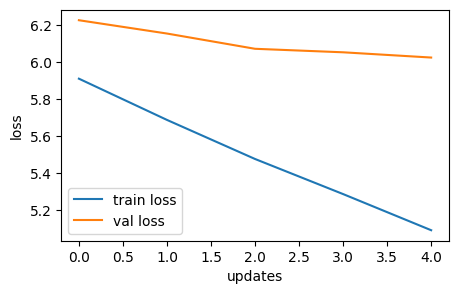

In [39]:
# Plot the losses
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(val_losses, label = 'val loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

In [40]:
# Evaluate the model with the test set
model.load_state_dict(torch.load(save_path))
test_loss = evaluate(model, test_loader, criterion, test_loader_length)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 6.016 | Test PPL: 410.081 |


### 6.2. Multiplicative Attention

In [53]:
# Initialize the model
attn = MultiplicativeAttention(hid_dim)
enc  = Encoder(input_dim,  emb_dim,  hid_dim, dropout)
dec  = Decoder(output_dim, emb_dim,  hid_dim, dropout, attn)

SRC_PAD_IDX = PAD_IDX

model = Seq2Seq(enc, dec, SRC_PAD_IDX, device).to(device)
model.apply(initialize_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(12131, 64)
    (rnn): GRU(64, 128, bidirectional=True)
    (fc): Linear(in_features=256, out_features=128, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): MultiplicativeAttention(
      (U): Linear(in_features=256, out_features=128, bias=True)
    )
    (embedding): Embedding(15568, 64)
    (gru): GRU(320, 128)
    (fc): Linear(in_features=448, out_features=15568, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [54]:
# Print the number of model parameters
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model)

776384
 24576
 49152
   384
   384
 24576
 49152
   384
   384
 32768
   128
 32768
   128
996352
122880
 49152
   384
   384
6974464
 15568
______
9150352


In [55]:
# Define loss and optimizer
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

In [56]:
# Train the model
best_val_loss = float('inf')
num_epochs = 5
clip       = 1

save_path = f'./models/Multiplicative{model.__class__.__name__}.pt'

train_losses = []
val_losses   = []

for epoch in range(num_epochs):
    
    start_time = time.time()

    train_loss = train(model, train_loader, optimizer, criterion, clip, train_loader_length)
    val_loss   = evaluate(model, val_loader, criterion, val_loader_length)
    
    #for plotting
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), save_path)
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {val_loss:.3f} |  Val. PPL: {math.exp(val_loss):7.3f}')
    
    #lower perplexity is better

Epoch: 01 | Time: 4m 12s
	Train Loss: 6.687 | Train PPL: 801.661
	 Val. Loss: 6.452 |  Val. PPL: 634.074
Epoch: 02 | Time: 4m 13s
	Train Loss: 6.266 | Train PPL: 526.274
	 Val. Loss: 6.382 |  Val. PPL: 590.999
Epoch: 03 | Time: 4m 10s
	Train Loss: 6.026 | Train PPL: 414.098
	 Val. Loss: 6.281 |  Val. PPL: 534.328
Epoch: 04 | Time: 4m 17s
	Train Loss: 5.816 | Train PPL: 335.715
	 Val. Loss: 6.197 |  Val. PPL: 491.499
Epoch: 05 | Time: 4m 19s
	Train Loss: 5.628 | Train PPL: 278.125
	 Val. Loss: 6.120 |  Val. PPL: 454.646


Text(0, 0.5, 'loss')

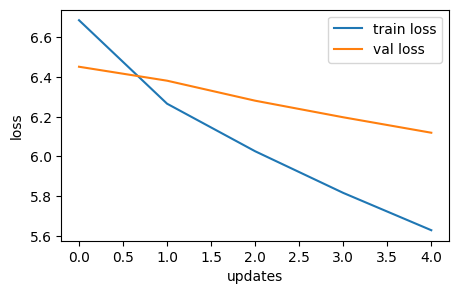

In [57]:
# Plot the losses
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(val_losses, label = 'val loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

In [58]:
# Evaluate the model with the test set
model.load_state_dict(torch.load(save_path))
test_loss = evaluate(model, test_loader, criterion, test_loader_length)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 6.118 | Test PPL: 453.844 |


### 6.3. General Attention

In [60]:
# Initialize the model
attn = GeneralAttention()
enc  = Encoder(input_dim,  emb_dim,  hid_dim, dropout)
dec  = Decoder(output_dim, emb_dim,  hid_dim, dropout, attn)

SRC_PAD_IDX = PAD_IDX

model = Seq2Seq(enc, dec, SRC_PAD_IDX, device).to(device)
model.apply(initialize_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(12131, 64)
    (rnn): GRU(64, 128, bidirectional=True)
    (fc): Linear(in_features=256, out_features=128, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): GeneralAttention()
    (embedding): Embedding(15568, 64)
    (gru): GRU(320, 128)
    (fc): Linear(in_features=448, out_features=15568, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [61]:
# Print the number of model parameters
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model)

776384
 24576
 49152
   384
   384
 24576
 49152
   384
   384
 32768
   128
996352
122880
 49152
   384
   384
6974464
 15568
______
9117456


In [62]:
# Define loss and optimizer
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

In [64]:
# Train the model
best_val_loss = float('inf')
num_epochs = 5
clip       = 1

save_path = f'./models/General{model.__class__.__name__}.pt'

train_losses = []
val_losses   = []

for epoch in range(num_epochs):
    
    start_time = time.time()

    train_loss = train(model, train_loader, optimizer, criterion, clip, train_loader_length)
    val_loss   = evaluate(model, val_loader, criterion, val_loader_length)
    
    #for plotting
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), save_path)
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {val_loss:.3f} |  Val. PPL: {math.exp(val_loss):7.3f}')
    
    #lower perplexity is better

Epoch: 01 | Time: 4m 17s
	Train Loss: 5.980 | Train PPL: 395.411
	 Val. Loss: 6.247 |  Val. PPL: 516.531
Epoch: 02 | Time: 4m 1s
	Train Loss: 5.778 | Train PPL: 322.959
	 Val. Loss: 6.191 |  Val. PPL: 488.420
Epoch: 03 | Time: 3m 58s
	Train Loss: 5.595 | Train PPL: 268.976
	 Val. Loss: 6.118 |  Val. PPL: 453.783
Epoch: 04 | Time: 3m 55s
	Train Loss: 5.426 | Train PPL: 227.129
	 Val. Loss: 6.115 |  Val. PPL: 452.791
Epoch: 05 | Time: 3m 54s
	Train Loss: 5.281 | Train PPL: 196.597
	 Val. Loss: 6.125 |  Val. PPL: 457.256


Text(0, 0.5, 'loss')

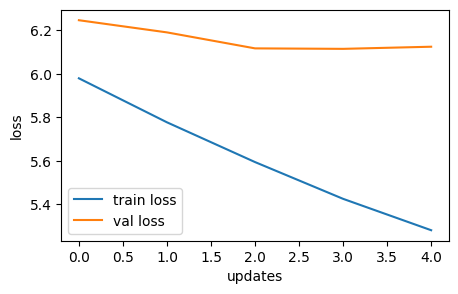

In [65]:
# Plot the losses
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(val_losses, label = 'val loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

In [66]:
# Evaluate the model with the test set
model.load_state_dict(torch.load(save_path))
test_loss = evaluate(model, test_loader, criterion, test_loader_length)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 6.106 | Test PPL: 448.499 |


### 6.4. Conclusion

Attention | Test Loss | Test PPL  |
--- | --- | ---  |
Additive | 6.016 | 410.081  |
Multiplicative | 6.118 | 453.844  |
General | 6.106 | 448.499  |

According to my model, the additive attention is the best attention.

## 7. Testing on Random Samples

In [90]:
sample = corpus[1]

In [91]:
sample[0], sample[1]

('ပါကစ္စတန် နိုင်ငံ ၏ အနောက်-မြောက် နယ်စပ် ပြည်နယ် တွင် နိုင်ငံရေး ဆိုင်ရာ ဆန္ဒပြပွဲ တစ် ခု အတွင်း အသေခံ ဗုံး ဖော်ခွဲမှု တစ် ခု ၌ လူ ၃၈ ယောက် သေဆုံးခဲ့ကြောင်း ပြောခဲ့သည် ။',
 '38 people were said to have died in a suicide bombing during a political rally in the North-West Frontier Province of Pakistan.')

In [92]:
src_text = text_transform[SRC_LANGUAGE](sample[0]).to(device)
src_text

tensor([   2,  629,   46,   11,  343,   48,  172, 1061,  133,   14,   46,   29,
          94, 1491,   16,   20,   89,  981,    0,  391,   13,   16,   20,   80,
        7256,   54,  110,    5,   79,   40,    5,    4,    8,    3],
       device='cuda:0')

In [93]:
trg_text = text_transform[TRG_LANGUAGE](sample[1]).to(device)
trg_text

tensor([   2, 2332,   50,   30,   28,    8,   24,  167,   10,   11,  601, 1450,
         113,   11,  304, 1926,   10,    4,  302,   17,  703, 5799, 2589,    7,
         583,    6,    3], device='cuda:0')

In [94]:
src_text = src_text.reshape(-1, 1)  #because batch_size is 1

In [95]:
trg_text = trg_text.reshape(-1, 1)

In [96]:
src_text.shape, trg_text.shape

(torch.Size([34, 1]), torch.Size([27, 1]))

In [97]:
text_length = torch.tensor([src_text.size(0)]).to(dtype=torch.int64)

In [98]:
attn = AdditiveAttention(hid_dim)
enc  = Encoder(input_dim,  emb_dim,  hid_dim, dropout)
dec  = Decoder(output_dim, emb_dim,  hid_dim, dropout, attn)

SRC_PAD_IDX = PAD_IDX

model = Seq2Seq(enc, dec, SRC_PAD_IDX, device).to(device)

model.load_state_dict(torch.load('./models/AdditiveSeq2Seq.pt'))

model.eval()
with torch.no_grad():
    output, attentions = model(src_text, text_length, trg_text, 0) #turn off teacher forcing

output = output.squeeze(1)

output = output[1:]

output_max = output.argmax(1) #returns max indices

print(output_max)

tensor([  59,  585, 1450,    7,   11,  106,   10,   11,   10,   11,   10,   11,
          10,   11,   10,   11,   10,   11,   10,   11,   10,    4,   10,    4,
           6,    3], device='cuda:0')


In [99]:
mapping = vocab_transform[TRG_LANGUAGE].get_itos()

for token in output_max:
    print(mapping[token.item()])

A
bomb
bombing
of
a
killed
in
a
in
a
in
a
in
a
in
a
in
a
in
a
in
the
in
the
.
<eos>
